In [1]:
import numpy as np
import pandas as pd
from glob import glob as glob

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

# 1. Data Preparation

In [4]:
# Load target values and corresponding scaler
targets = pd.read_csv('datasets/targets.csv')
targets = targets.rename(columns={'Unnamed: 0': 'Id'}).set_index('Id')
feature_transform = True

import joblib
scaler_targets = joblib.load('datasets/targets_scaler.pkl')

In [5]:
# Extract ID for train and test set
train_id = targets.index.values
sample_submission = pd.read_csv('sample_submission.csv')
test_id = np.unique(sample_submission.Id.str.split('_', expand=True)[0].astype('int'))

# 2. Modeling

In [6]:
def load_dataset(dataset_id, target):

    # Load dataset
    X_tr = pd.read_csv('datasets/%s_train.csv' % dataset_id)
    X_te = pd.read_csv('datasets/%s_test.csv' % dataset_id)

    # Specify target
    y = pd.read_csv('datasets/targets.csv')
    y = y.rename(columns={'Unnamed: 0': 'Id'}).set_index('Id')
    y_tr = y.iloc[X_tr.index][target]

    # Remove missing values
    missval = y_tr.isnull().values
    idx = ~missval
    X_tr = X_tr[idx]
    y_tr = y_tr[idx]
    print('Removing %s missing values from target dataset.' % missval.sum())
    
    return X_tr, X_te, y_tr, idx

In [7]:
# Create scorer function
from sklearn.metrics import make_scorer
def model_metric(y_true, y_pred, scaler=None, tidx=0):
    t_true = scaler.inverse_transform(np.transpose([y_true] * 5))[:, tidx]
    t_pred = scaler.inverse_transform(np.transpose([y_pred] * 5))[:, tidx]
    
    if tidx == 0:
        age_values = np.unique(t_true)
        for i, a in enumerate(t_pred):
            t_pred[i] = age_values[np.argmin(np.abs(a-age_values))]

    if tidx > 0:
        t_true = np.power(t_true, 1./1.5)
        t_pred = np.power(t_pred, 1./1.5)
    score = np.mean(np.sum(np.abs(t_true - t_pred), axis=0) / np.sum(t_true, axis=0))
    return score

In [8]:
def create_grid(model_metric, estimator=None, cv=5, scaler_targets=None, tidx=0):

    # Create Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('estimator', estimator),
    ])

    # Define parameter grid
    alphas = np.logspace(2.5, 3.5, 20)
    param_grid = [
    { 
        'scaler': [RobustScaler(),
                   PowerTransformer()
                   ],
        'pca': [None],
        'estimator__tol': [1e-4],
        'estimator__alpha': alphas
    }
    ]

    # Create grid search object
    f_scorer = make_scorer(model_metric, greater_is_better=False, scaler=scaler_targets, tidx=tidx)
    grid = GridSearchCV(pipeline,
                        cv=cv,
                        param_grid=param_grid,
                        scoring=f_scorer,
                        return_train_score=True,
                        verbose=1,
                        n_jobs=-1)

    return grid

In [9]:
def extract_predictions(X_tr, X_te, grid, target, targets, truncate_top=5):

    # Store predictions in dictionary
    res = {}
    res['tr'] = grid.predict(X_tr)
    res['te'] = grid.predict(X_te)

    # Assign age to correct bin
    if target == 'age':
        age_values = np.unique(targets.age)
        for t in ['tr', 'te']:
            age_pred_tr = res['%s' % t]
            for i, a in enumerate(age_pred_tr):
                age_pred_tr[i] = age_values[np.argmin(np.abs(a-age_values))]

    # Put upper and lower ceiling on predictions
    pred_order = res['te'].argsort()
    res['te'][pred_order[:truncate_top]] = res['te'][pred_order[truncate_top]]
    res['te'][pred_order[-truncate_top:]] = res['te'][pred_order[-truncate_top]]

    print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
    
    return res['tr'], res['te']

In [10]:
def plot_predictions(pred_tr, pred_te, y_tr):

    # Plot prediction descrepancy on training and test set
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sns.regplot(x=pred_tr, y=y_tr, marker='.', ax=ax[0])
    ax[0].set_title('Prediction X_tr: %s' % target)
    ax[0].set_xlim(ax[0].get_ylim())
    
    ax[1].plot(pred_te, '.', alpha=0.5)
    ax[1].plot(pred_tr, '.', alpha=0.3)
    ax[1].set_title('Prediction X_te: %s' % target)
    plt.show()

In [11]:
def create_df_pred(grid):

    # Store grid search parameters and outcomes in dataframe
    df_pred = pd.DataFrame(grid.cv_results_)
    columns = [c for c in df_pred.columns if 'time' not in c
               and 'split' not in c
               and 'rank' not in c
               and c!='params']
    df_pred = df_pred[columns].sort_values('mean_test_score', ascending=False)
    df_pred['param_scaler'] = df_pred['param_scaler'].astype('str')
    df_pred['param_pca'] = df_pred['param_pca'].astype('str')
    df_pred['param_estimator__alpha'] = df_pred['param_estimator__alpha'].astype('float')
    
    return df_pred

In [12]:
def plot_hyperparam_fitting(df_pred):

    # Plot the model fit information
    for p in df_pred['param_pca'].unique():
        for s in df_pred['param_scaler'].unique():

            df_plot = df_pred[np.prod([df_pred['param_pca']==p,
                                       df_pred['param_scaler']==s],
                                      axis=0).astype('bool')]
            df_plot = df_plot.sort_values('param_estimator__alpha')
            
            # Skip hyperparameter combination if not explored
            if df_plot.shape[0] == 0:
                continue

            # Extract relevant modelling metrics
            train_scores = df_plot['mean_train_score']
            valid_scores = df_plot['mean_test_score']
            std_tr = df_plot['std_train_score']
            std_va = df_plot['std_test_score']

            plt.figure(figsize=(12, 4))
            alphas = df_plot['param_estimator__alpha']
            plt.semilogx(alphas, train_scores, label='Training Set')
            plt.semilogx(alphas, valid_scores, label='Validation Set')

            # Add marker and text for best score
            max_id = np.argmax(valid_scores)
            x_pos = alphas.iloc[max_id]
            y_pos = valid_scores.iloc[max_id]
            txt = '{:0.4f}'.format(y_pos)
            plt.scatter(x_pos, y_pos, marker='x', c='red', zorder=10)
            plt.text(x_pos, y_pos, txt, fontdict={'size': 18})

            # Quantify variance with ±std curves
            plt.fill_between(alphas, train_scores-std_tr, train_scores+std_tr, alpha=0.3)
            plt.fill_between(alphas, valid_scores-std_va, valid_scores+std_va, alpha=0.3)
            plt.ylabel('Performance metric')
            plt.xlabel('Model parameter')

            # Adjust x-lim, y-lim, add legend and adjust layout
            plt.legend()
            plt.title('%s\n%s' % (str(s), str(p)))
            plt.show()

In [13]:
def run_prediction(model_metric, dataset_id='merge', target='age', estimator=None, scaler_targets=None, tidx=0):
    
    # Extract dataset
    X_tr, X_te, y_tr, idx = load_dataset(dataset_id, target)
    print('Size of dataset: ', X_tr.shape)
    
    # Create grid search object
    grid = create_grid(model_metric, estimator=estimator, scaler_targets=scaler_targets, tidx=tidx)
    
    # Run grid search
    res = grid.fit(X_tr, y_tr)
    
    # Compute predictions
    pred_tr, pred_te = extract_predictions(X_tr, X_te, grid, target, targets)
    
    # Plot predictions
    plot_predictions(pred_tr, pred_te, y_tr)
    
    # Create prediction dataframe
    df_pred = create_df_pred(grid)
    
    # Plot prediction behaviour
    plot_hyperparam_fitting(df_pred)
    
    return df_pred, pred_tr, pred_te, grid, idx

In [14]:
def display_grid_optimization_details(grid):
    df_cv = pd.DataFrame(grid.cv_results_)
    selecter = df_cv.columns.str.contains('param_') + \
               df_cv.columns.str.contains('mean') + \
               df_cv.columns.str.contains('std')
    df_cv = df_cv.loc[:, selecter]
    df_cv = df_cv.loc[:, ~df_cv.columns.str.contains('_time')]
    display(df_cv.sort_values('mean_test_score', ascending=False)[:10])

In [15]:
def create_results_dataframe(predictions, scaler_targets, targets, test_id, feature_transform, res_type='_te'):

    # Collect results
    t_keys = [k for k in predictions.keys() if res_type in k]
    results = np.transpose([predictions[k] for k in t_keys])

    # Reset scaling
    results = scaler_targets.inverse_transform(results)

    # Store results in Dataframe
    if res_type=='_te':
        df_results = pd.DataFrame(results, columns=targets.columns)

    elif res_type=='_tr':
        # Get location of missing values
        miss_columns = [k for k in predictions.keys() if 'miss' in k]
        entries = np.transpose([predictions[k] for k in miss_columns])

        # Create dataframe and fill up missing value places with NaN
        df_results = pd.concat(
            [pd.Series(dict(zip(train_id[entries[:, c]].astype('str'), results[c])))
             for c in range(len(miss_columns))], axis=1)
        df_results.columns = targets.columns

    # Reset feature transformation
    if feature_transform:
        for col in df_results.columns[1:]:
            df_results[col] = np.power(df_results[col], 1./1.5)

    # Assign age to correct bin
    age_values = np.unique(scaler_targets.inverse_transform(targets)[:, 0])
    for i, a in enumerate(df_results.age):
        df_results.age[i] = age_values[np.argmin(np.abs(a-age_values))]

    # Add ID back to test results
    if res_type=='_te':
        df_results.insert(0, 'Id', test_id)
        df_results.set_index('Id', inplace=True)
    
    return df_results

In [16]:
def grids_summary(grids):

    grid_content = []
    for g in grids:

        column_name = []
        temp = []
        for k in g.best_params_:
            column_name.append(k)
            temp.append(g.best_params_[k])
        column_name.insert(0, 'score')
        temp.insert(0, -np.round(g.best_score_, 6))
        grid_content.append(temp)


    df_grid = pd.DataFrame(grid_content, columns=column_name)
    display(df_grid)

In [17]:
def save_results(predictions, scaler_targets, targets, test_id, feature_transform,
                 sample_submission, dataset_id, score_postfix):
    
    # Get results dataframe
    df_results_tr = create_results_dataframe(predictions, scaler_targets, targets,
                                             test_id, feature_transform, res_type='_tr')
    df_results_te = create_results_dataframe(predictions, scaler_targets, targets,
                                             test_id, feature_transform, res_type='_te')
    
    # Store test results in CSV file
    score_postfix = '_'.join(np.array(score_postfix).astype('str'))
    submission = sample_submission.copy()
    submission['Predicted'] = np.ravel(df_results_te)
    submission.to_csv('results/submission_ridge_age_%s_%s.csv' % (dataset_id, score_postfix), index=False)
    
    # Store dataframes in CSV files
    df_results_tr.to_csv('results/results_tr_ridge_age_%s_%s.csv' % (dataset_id, score_postfix), index=False)
    df_results_te.to_csv('results/results_te_ridge_age_%s_%s.csv' % (dataset_id, score_postfix), index=False)

    return df_results_tr, df_results_te

In [18]:
def plot_prediction_distributions(targets, scaler_targets, df_results_tr, df_results_te):
    
    # Recreate original target dataset
    df_results = pd.DataFrame(scaler_targets.inverse_transform(targets),
                              columns=targets.columns)

    # Reset feature transformation
    if feature_transform:
        for col in df_results.columns[1:]:
            df_results[col] = np.power(df_results[col], 1./1.5)

    # Compare target distributions of train and test set
    for c in df_results.columns:
        plt.figure(figsize=(5, 5))
        plt.title(c)
        plt.hist(df_results[c], bins=25, alpha=0.5, density=True)
        plt.hist(df_results_te[c], bins=25, alpha=0.5, density=True)
        plt.hist(df_results_tr[c], bins=25, alpha=0.5, density=True)
        plt.legend(['orig', 'test', 'train'])
        plt.show()

In [19]:
# Show list of available datasets
sorted(glob('datasets/*train.csv'))

['datasets/merge_train.csv', 'datasets/short_merge_train.csv']

Starting with dataset merge - target: age
Removing 0 missing values from target dataset.
Size of dataset:  (5865, 1405)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best: -0.143970 using {'estimator__alpha': 579.6393953384967, 'estimator__tol': 0.0001, 'pca': None, 'scaler': RobustScaler()}


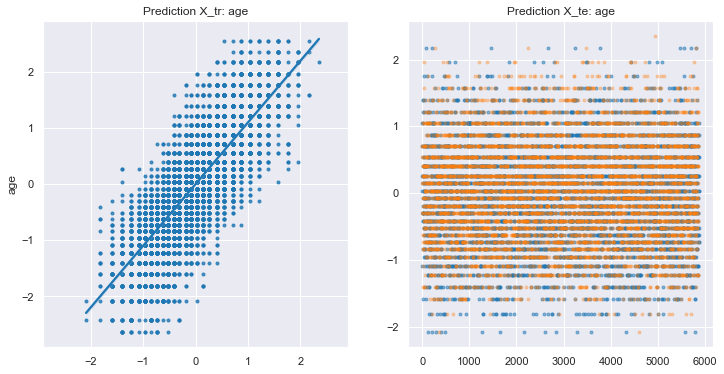

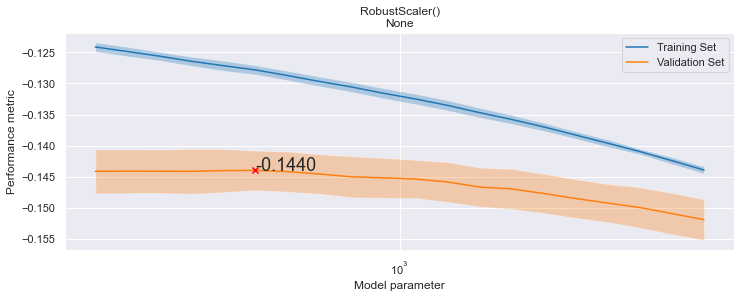

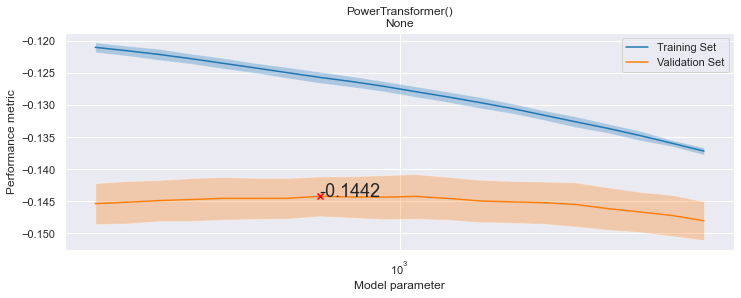

,param_estimator__alpha,param_estimator__tol,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
10,579.639,0.0001,None,RobustScaler(),-0.143970,0.003169,-0.127824,0.000738
8,513.483,0.0001,None,RobustScaler(),-0.144003,0.003474,-0.127145,0.000806
2,356.97,0.0001,None,RobustScaler(),-0.144103,0.003519,-0.124867,0.000755
4,402.961,0.0001,None,RobustScaler(),-0.144110,0.003485,-0.125607,0.000689
0,316.228,0.0001,None,RobustScaler(),-0.144120,0.003515,-0.124136,0.000729
6,454.878,0.0001,None,RobustScaler(),-0.144129,0.003604,-0.126434,0.000734
12,654.319,0.0001,None,RobustScaler(),-0.144172,0.003231,-0.128726,0.000754
15,738.62,0.0001,None,PowerTransformer(),-0.144215,0.003100,-0.125646,0.000877
21,1062.47,0.0001,None,PowerTransformer(),-0.144228,0.003483,-0.127880,0.000822
17,833.782,0.0001,None,PowerTransformer(),-0.144315,0.003225,-0.126300,0.000839


Starting with dataset merge - target: domain1_var1
Removing 437 missing values from target dataset.
Size of dataset:  (5428, 1405)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.2min finished


Best: -0.152390 using {'estimator__alpha': 3162.2776601683795, 'estimator__tol': 0.0001, 'pca': None, 'scaler': RobustScaler()}


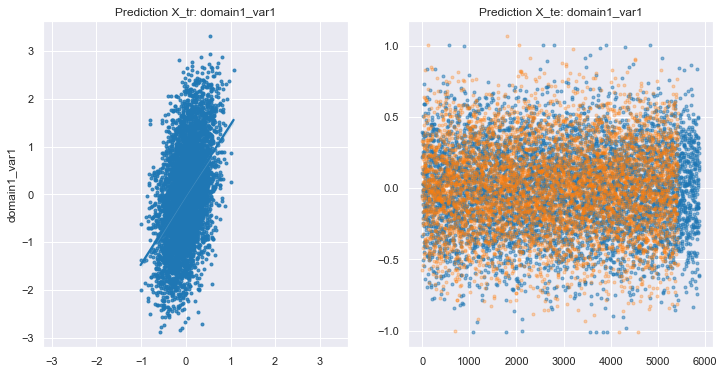

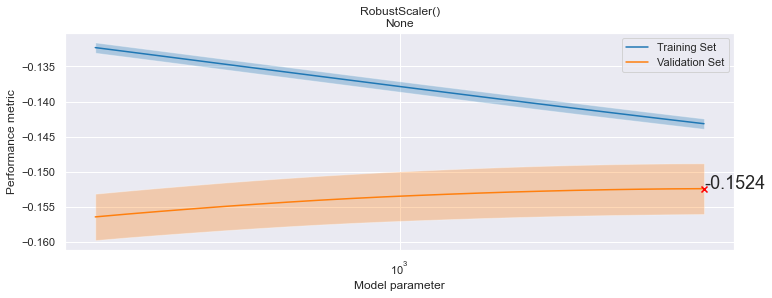

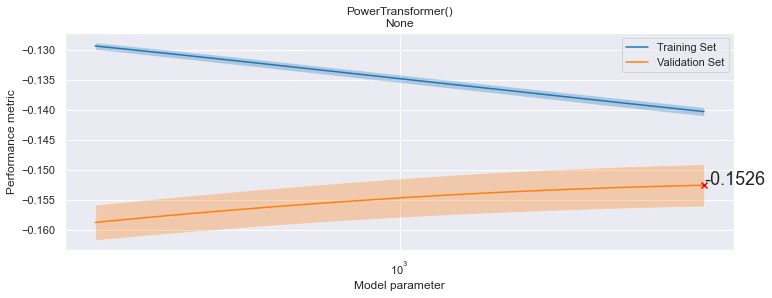

,param_estimator__alpha,param_estimator__tol,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
38,3162.28,0.0001,None,RobustScaler(),-0.152390,0.003603,-0.143154,0.000733
36,2801.36,0.0001,None,RobustScaler(),-0.152419,0.003614,-0.142618,0.000735
34,2481.63,0.0001,None,RobustScaler(),-0.152470,0.003616,-0.142076,0.000740
32,2198.39,0.0001,None,RobustScaler(),-0.152539,0.003610,-0.141530,0.000749
39,3162.28,0.0001,None,PowerTransformer(),-0.152602,0.003508,-0.140304,0.000725
30,1947.48,0.0001,None,RobustScaler(),-0.152629,0.003602,-0.140980,0.000757
37,2801.36,0.0001,None,PowerTransformer(),-0.152732,0.003495,-0.139737,0.000725
28,1725.21,0.0001,None,RobustScaler(),-0.152741,0.003593,-0.140422,0.000763
26,1528.31,0.0001,None,RobustScaler(),-0.152869,0.003581,-0.139862,0.000764
35,2481.63,0.0001,None,PowerTransformer(),-0.152881,0.003480,-0.139168,0.000721


Starting with dataset merge - target: domain1_var2
Removing 437 missing values from target dataset.
Size of dataset:  (5428, 1405)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.2min finished


Best: -0.151627 using {'estimator__alpha': 3162.2776601683795, 'estimator__tol': 0.0001, 'pca': None, 'scaler': RobustScaler()}


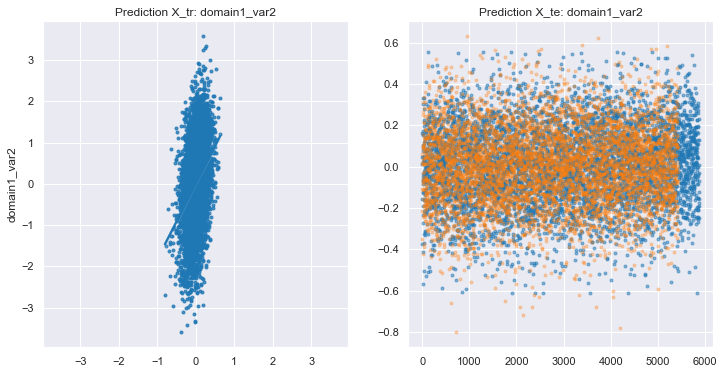

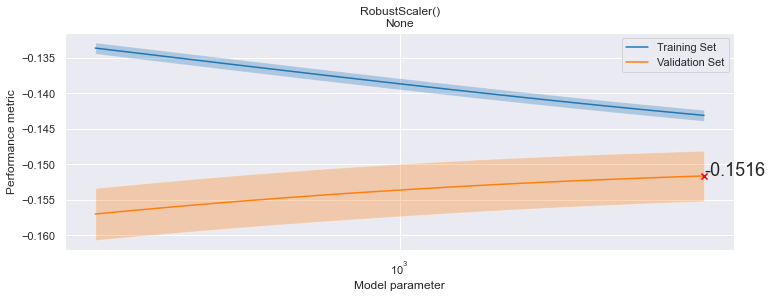

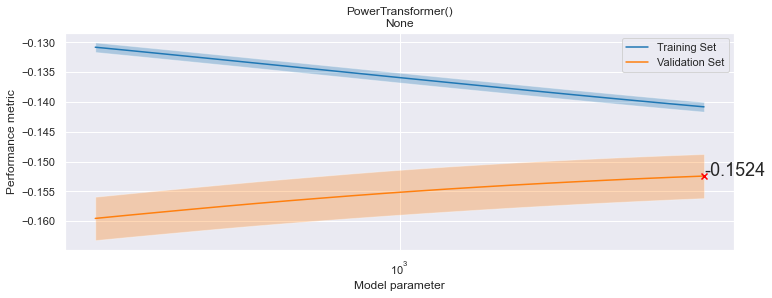

,param_estimator__alpha,param_estimator__tol,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
38,3162.28,0.0001,None,RobustScaler(),-0.151627,0.003551,-0.143094,0.000786
36,2801.36,0.0001,None,RobustScaler(),-0.151782,0.003568,-0.142672,0.000786
34,2481.63,0.0001,None,RobustScaler(),-0.151948,0.003584,-0.142239,0.000787
32,2198.39,0.0001,None,RobustScaler(),-0.152123,0.003602,-0.141794,0.000787
30,1947.48,0.0001,None,RobustScaler(),-0.152309,0.003616,-0.141336,0.000789
39,3162.28,0.0001,None,PowerTransformer(),-0.152431,0.003696,-0.140824,0.000808
28,1725.21,0.0001,None,RobustScaler(),-0.152509,0.003628,-0.140867,0.000791
37,2801.36,0.0001,None,PowerTransformer(),-0.152641,0.003710,-0.140339,0.000809
26,1528.31,0.0001,None,RobustScaler(),-0.152728,0.003645,-0.140387,0.000794
35,2481.63,0.0001,None,PowerTransformer(),-0.152871,0.003725,-0.139845,0.000811


Starting with dataset merge - target: domain2_var1
Removing 39 missing values from target dataset.
Size of dataset:  (5826, 1405)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.4min finished


Best: -0.182186 using {'estimator__alpha': 3162.2776601683795, 'estimator__tol': 0.0001, 'pca': None, 'scaler': RobustScaler()}


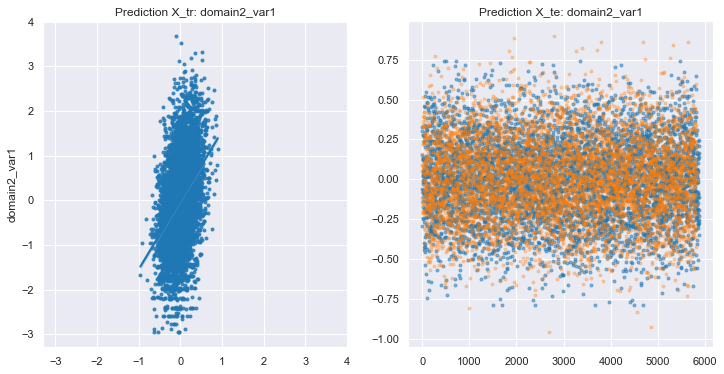

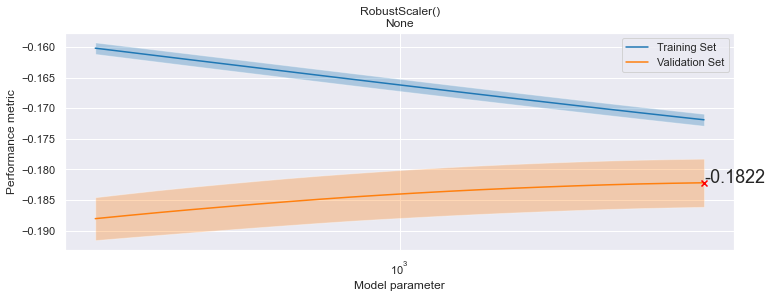

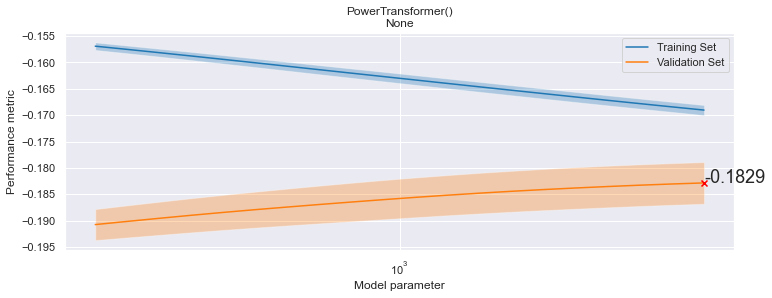

,param_estimator__alpha,param_estimator__tol,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
38,3162.28,0.0001,None,RobustScaler(),-0.182186,0.003932,-0.171895,0.000977
36,2801.36,0.0001,None,RobustScaler(),-0.182271,0.003942,-0.171324,0.000975
34,2481.63,0.0001,None,RobustScaler(),-0.182378,0.003950,-0.170745,0.000972
32,2198.39,0.0001,None,RobustScaler(),-0.182519,0.003954,-0.170158,0.000973
30,1947.48,0.0001,None,RobustScaler(),-0.182688,0.003959,-0.169563,0.000975
39,3162.28,0.0001,None,PowerTransformer(),-0.182858,0.003954,-0.169034,0.000955
28,1725.21,0.0001,None,RobustScaler(),-0.182882,0.003961,-0.168962,0.000980
37,2801.36,0.0001,None,PowerTransformer(),-0.183062,0.003952,-0.168427,0.000956
26,1528.31,0.0001,None,RobustScaler(),-0.183093,0.003959,-0.168358,0.000984
35,2481.63,0.0001,None,PowerTransformer(),-0.183288,0.003950,-0.167811,0.000953


Starting with dataset merge - target: domain2_var2
Removing 39 missing values from target dataset.
Size of dataset:  (5826, 1405)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.4min finished


Best: -0.176602 using {'estimator__alpha': 3162.2776601683795, 'estimator__tol': 0.0001, 'pca': None, 'scaler': RobustScaler()}


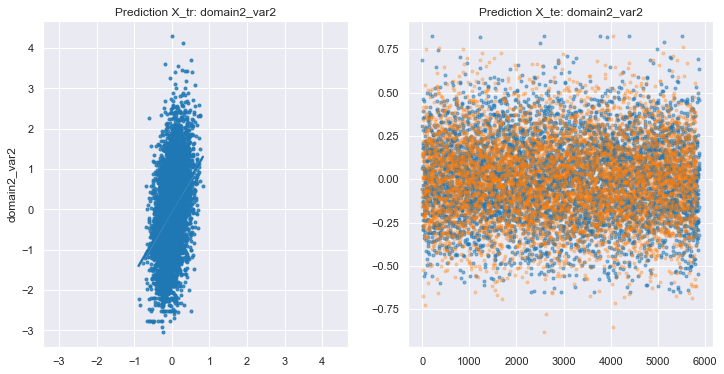

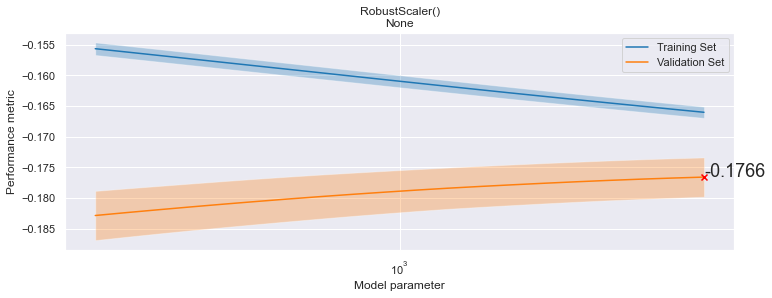

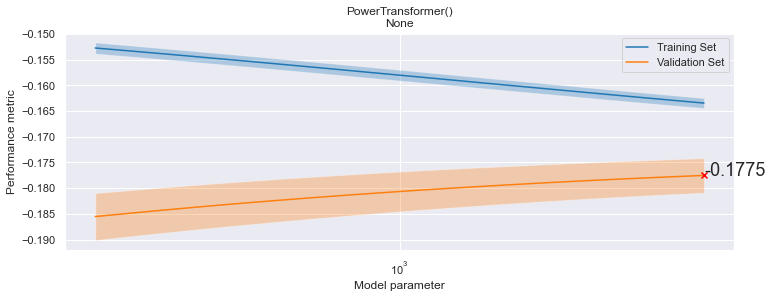

,param_estimator__alpha,param_estimator__tol,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
38,3162.28,0.0001,None,RobustScaler(),-0.176602,0.003202,-0.166039,0.000914
36,2801.36,0.0001,None,RobustScaler(),-0.176763,0.003216,-0.165530,0.000922
34,2481.63,0.0001,None,RobustScaler(),-0.176943,0.003228,-0.165016,0.000929
32,2198.39,0.0001,None,RobustScaler(),-0.177146,0.003241,-0.164495,0.000934
30,1947.48,0.0001,None,RobustScaler(),-0.177370,0.003261,-0.163970,0.000941
39,3162.28,0.0001,None,PowerTransformer(),-0.177515,0.003365,-0.163444,0.000976
28,1725.21,0.0001,None,RobustScaler(),-0.177609,0.003283,-0.163439,0.000948
37,2801.36,0.0001,None,PowerTransformer(),-0.177773,0.003399,-0.162895,0.000988
26,1528.31,0.0001,None,RobustScaler(),-0.177864,0.003307,-0.162904,0.000957
35,2481.63,0.0001,None,PowerTransformer(),-0.178045,0.003435,-0.162337,0.001000


,score,estimator__alpha,estimator__tol,pca,scaler
0,0.143970,579.639395,0.0001,None,RobustScaler()
1,0.152390,3162.277660,0.0001,None,RobustScaler()
2,0.151627,3162.277660,0.0001,None,RobustScaler()
3,0.182186,3162.277660,0.0001,None,RobustScaler()
4,0.176602,3162.277660,0.0001,None,RobustScaler()


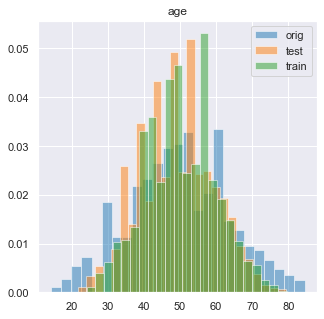

/home/mnotter/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mnotter/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


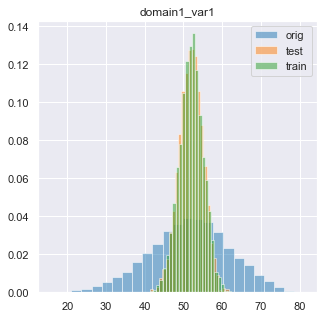

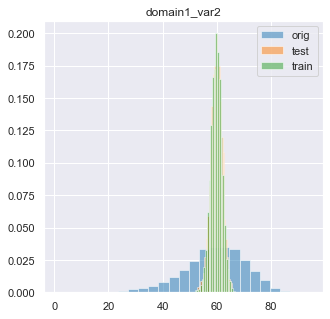

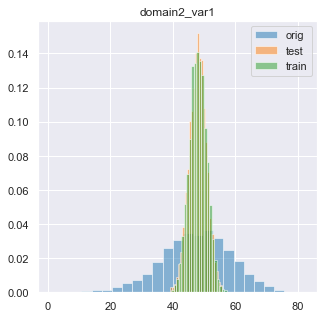

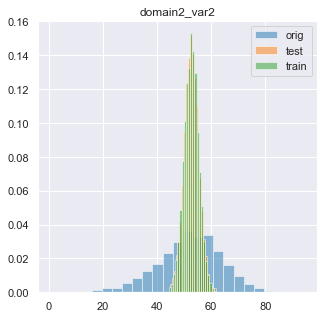

Score: 0.1592 | -0.1440 -0.1524 -0.1516 -0.1822 -0.1766


In [20]:
datasets_to_check = ['merge']

for dataset_id in datasets_to_check:

    predictions = {}
    scores = []
    grids = []

    for tidx, target in enumerate(['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']):

        print('Starting with dataset %s - target: %s' % (dataset_id, target))
        estimator = Ridge()
        df_pred, pred_tr, pred_te, grid, idx = run_prediction(model_metric,
            dataset_id=dataset_id, target=target, estimator=estimator,
            scaler_targets=scaler_targets, tidx=tidx)
        
        display_grid_optimization_details(grid)

        predictions['%s_tr' % target] = pred_tr
        predictions['%s_te' % target] = pred_te
        predictions['%s_miss' % target] = idx
        
        scores.append(grid.best_score_)
        grids.append(grid)

    # Display grids summary
    grids_summary(grids)
    
    # Compute overall score
    weights = [.3, .175, .175, .175, .175]
    score = np.sum([-s * weights[i] for i, s in enumerate(scores)])
    score_postfix = [int(score*10000)] + [-int(s*10000) for i, s in enumerate(scores)]

    df_results_tr, df_results_te = save_results(
        predictions, scaler_targets, targets, test_id, feature_transform,
        sample_submission, dataset_id, score_postfix)

    plot_prediction_distributions(targets, scaler_targets, df_results_tr, df_results_te)
    
    # Feedback of overall score
    txt = 'Score: {:.4f} | {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(score, *scores)
    print(txt)

Starting with dataset short_merge - target: age
Removing 0 missing values from target dataset.
Size of dataset:  (5825, 1655)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.8min finished


Best: -0.143512 using {'estimator__alpha': 941.2049672680671, 'estimator__tol': 0.0001, 'pca': None, 'scaler': PowerTransformer()}


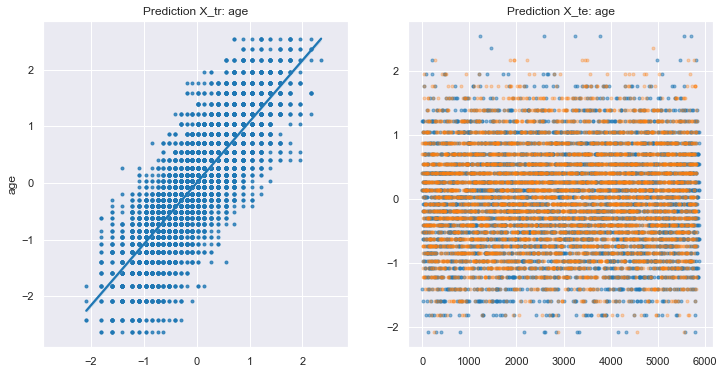

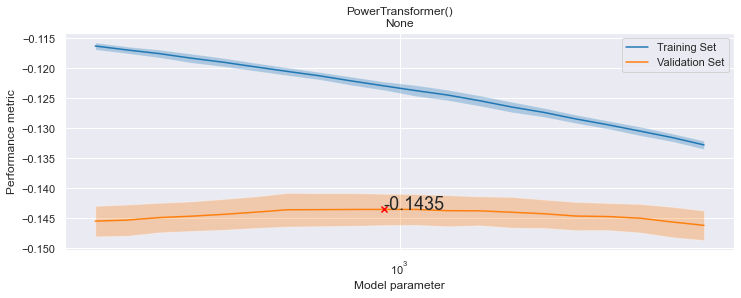

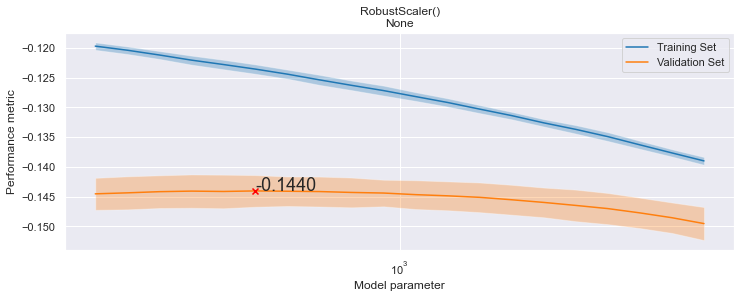

,param_estimator__alpha,param_estimator__tol,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
19,941.205,0.0001,None,PowerTransformer(),-0.143512,0.002616,-0.122893,0.000722
21,1062.47,0.0001,None,PowerTransformer(),-0.143513,0.002570,-0.123690,0.000922
17,833.782,0.0001,None,PowerTransformer(),-0.143520,0.002719,-0.122084,0.000718
15,738.62,0.0001,None,PowerTransformer(),-0.143551,0.002754,-0.121223,0.000643
13,654.319,0.0001,None,PowerTransformer(),-0.143567,0.002805,-0.120493,0.000665
23,1199.35,0.0001,None,PowerTransformer(),-0.143723,0.002596,-0.124435,0.000895
25,1353.88,0.0001,None,PowerTransformer(),-0.143749,0.002417,-0.125383,0.000884
11,579.639,0.0001,None,PowerTransformer(),-0.143971,0.002632,-0.119737,0.000684
27,1528.31,0.0001,None,PowerTransformer(),-0.143986,0.002567,-0.126428,0.000881
10,579.639,0.0001,None,RobustScaler(),-0.144049,0.002658,-0.123573,0.000784


Starting with dataset short_merge - target: domain1_var1
Removing 435 missing values from target dataset.
Size of dataset:  (5390, 1655)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.6min finished


Best: -0.150113 using {'estimator__alpha': 3162.2776601683795, 'estimator__tol': 0.0001, 'pca': None, 'scaler': RobustScaler()}


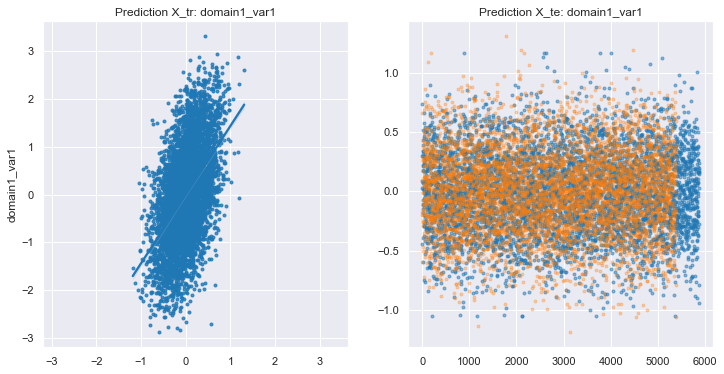

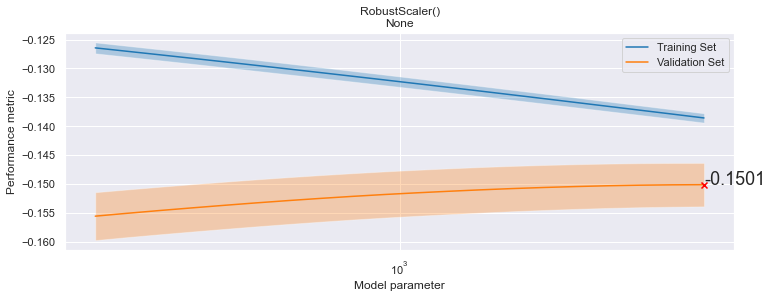

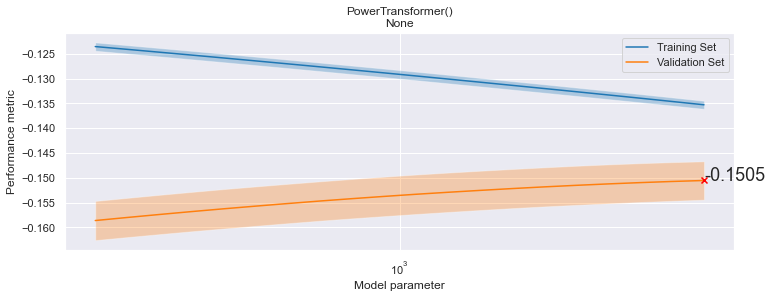

,param_estimator__alpha,param_estimator__tol,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
38,3162.28,0.0001,None,RobustScaler(),-0.150113,0.003758,-0.138566,0.000805
36,2801.36,0.0001,None,RobustScaler(),-0.150145,0.003784,-0.137890,0.000809
34,2481.63,0.0001,None,RobustScaler(),-0.150207,0.003808,-0.137222,0.000818
32,2198.39,0.0001,None,RobustScaler(),-0.150306,0.003835,-0.136553,0.000831
30,1947.48,0.0001,None,RobustScaler(),-0.150440,0.003863,-0.135884,0.000843
39,3162.28,0.0001,None,PowerTransformer(),-0.150546,0.003867,-0.135270,0.000811
28,1725.21,0.0001,None,RobustScaler(),-0.150605,0.003892,-0.135218,0.000850
37,2801.36,0.0001,None,PowerTransformer(),-0.150743,0.003896,-0.134599,0.000817
26,1528.31,0.0001,None,RobustScaler(),-0.150796,0.003920,-0.134558,0.000861
35,2481.63,0.0001,None,PowerTransformer(),-0.150976,0.003917,-0.133931,0.000825


Starting with dataset short_merge - target: domain1_var2
Removing 435 missing values from target dataset.
Size of dataset:  (5390, 1655)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.6min finished


Best: -0.147782 using {'estimator__alpha': 3162.2776601683795, 'estimator__tol': 0.0001, 'pca': None, 'scaler': RobustScaler()}


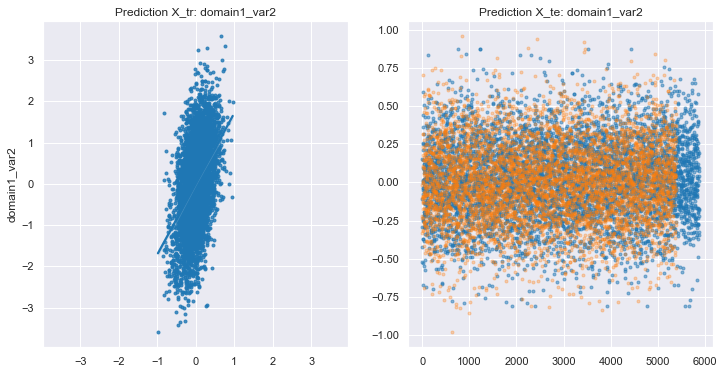

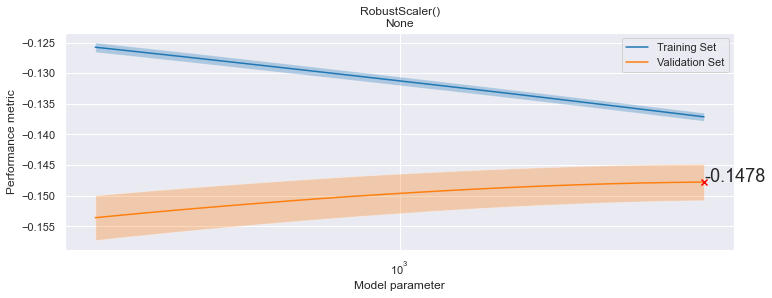

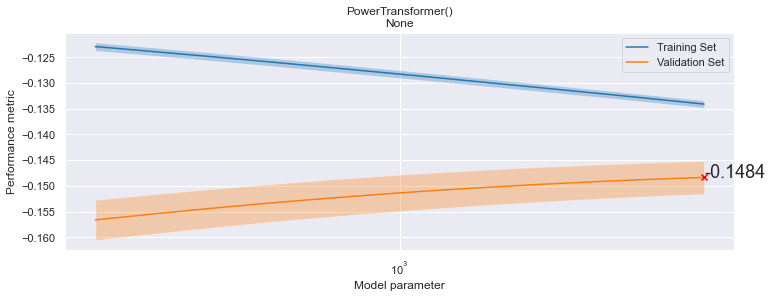

,param_estimator__alpha,param_estimator__tol,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
38,3162.28,0.0001,None,RobustScaler(),-0.147782,0.002955,-0.137127,0.000678
36,2801.36,0.0001,None,RobustScaler(),-0.147848,0.002977,-0.136493,0.000676
34,2481.63,0.0001,None,RobustScaler(),-0.147945,0.003001,-0.135858,0.000675
32,2198.39,0.0001,None,RobustScaler(),-0.148077,0.003028,-0.135224,0.000675
30,1947.48,0.0001,None,RobustScaler(),-0.148243,0.003054,-0.134597,0.000679
39,3162.28,0.0001,None,PowerTransformer(),-0.148355,0.003228,-0.134086,0.000713
28,1725.21,0.0001,None,RobustScaler(),-0.148434,0.003075,-0.133974,0.000683
37,2801.36,0.0001,None,PowerTransformer(),-0.148567,0.003254,-0.133450,0.000716
26,1528.31,0.0001,None,RobustScaler(),-0.148654,0.003101,-0.133357,0.000689
35,2481.63,0.0001,None,PowerTransformer(),-0.148810,0.003284,-0.132817,0.000720


Starting with dataset short_merge - target: domain2_var1
Removing 39 missing values from target dataset.
Size of dataset:  (5786, 1655)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.7min finished


Best: -0.180025 using {'estimator__alpha': 3162.2776601683795, 'estimator__tol': 0.0001, 'pca': None, 'scaler': RobustScaler()}


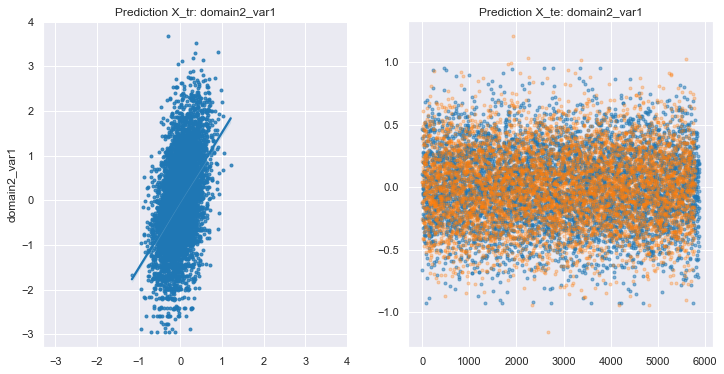

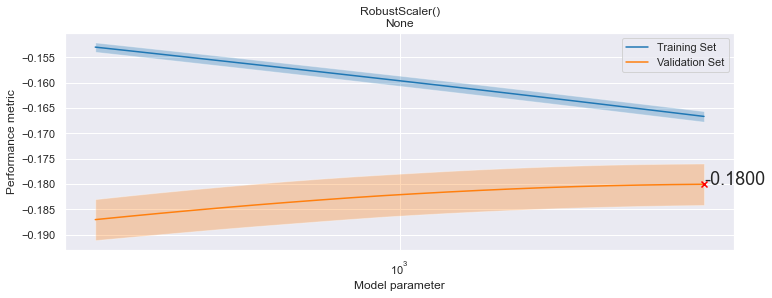

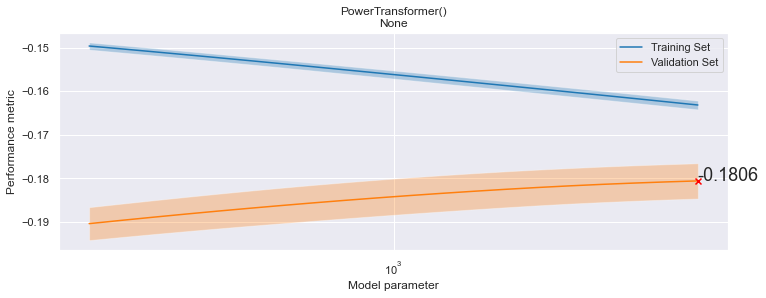

,param_estimator__alpha,param_estimator__tol,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
38,3162.28,0.0001,None,RobustScaler(),-0.180025,0.004084,-0.166658,0.001039
36,2801.36,0.0001,None,RobustScaler(),-0.180091,0.004100,-0.165901,0.001037
34,2481.63,0.0001,None,RobustScaler(),-0.180188,0.004116,-0.165148,0.001032
32,2198.39,0.0001,None,RobustScaler(),-0.180319,0.004132,-0.164397,0.001032
30,1947.48,0.0001,None,RobustScaler(),-0.180490,0.004130,-0.163648,0.001033
39,3162.28,0.0001,None,PowerTransformer(),-0.180603,0.004047,-0.163166,0.001002
28,1725.21,0.0001,None,RobustScaler(),-0.180701,0.004128,-0.162903,0.001033
37,2801.36,0.0001,None,PowerTransformer(),-0.180838,0.004054,-0.162411,0.001001
26,1528.31,0.0001,None,RobustScaler(),-0.180955,0.004134,-0.162166,0.001031
35,2481.63,0.0001,None,PowerTransformer(),-0.181103,0.004065,-0.161658,0.000998


Starting with dataset short_merge - target: domain2_var2
Removing 39 missing values from target dataset.
Size of dataset:  (5786, 1655)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.7min finished


Best: -0.173676 using {'estimator__alpha': 3162.2776601683795, 'estimator__tol': 0.0001, 'pca': None, 'scaler': RobustScaler()}


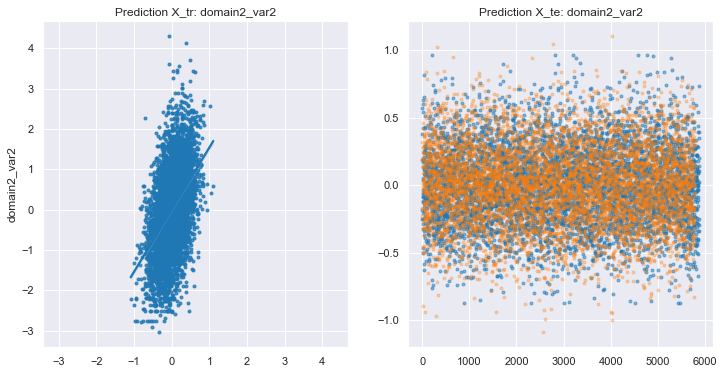

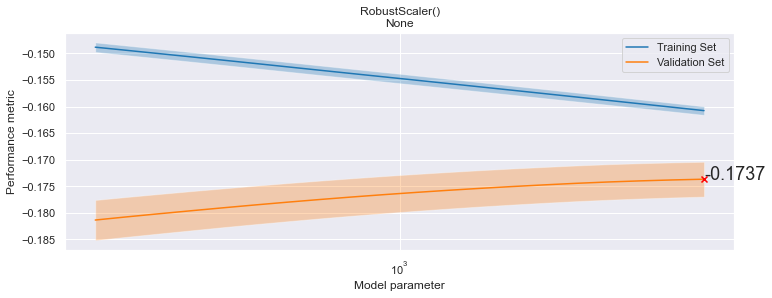

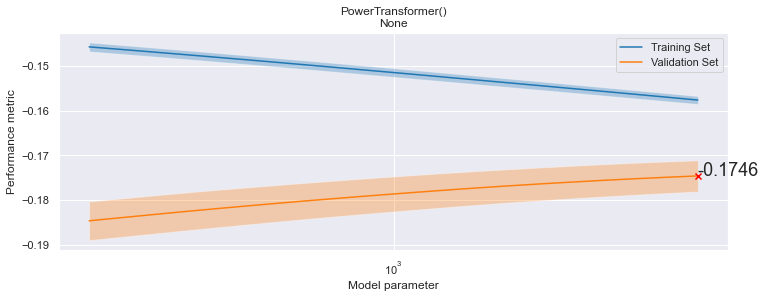

,param_estimator__alpha,param_estimator__tol,param_pca,param_scaler,mean_test_score,std_test_score,mean_train_score,std_train_score
38,3162.28,0.0001,None,RobustScaler(),-0.173676,0.003275,-0.160768,0.000799
36,2801.36,0.0001,None,RobustScaler(),-0.173817,0.003293,-0.160120,0.000805
34,2481.63,0.0001,None,RobustScaler(),-0.173992,0.003317,-0.159475,0.000814
32,2198.39,0.0001,None,RobustScaler(),-0.174201,0.003339,-0.158833,0.000823
30,1947.48,0.0001,None,RobustScaler(),-0.174453,0.003353,-0.158194,0.000834
39,3162.28,0.0001,None,PowerTransformer(),-0.174605,0.003493,-0.157591,0.000886
28,1725.21,0.0001,None,RobustScaler(),-0.174747,0.003370,-0.157556,0.000844
37,2801.36,0.0001,None,PowerTransformer(),-0.174916,0.003533,-0.156925,0.000900
26,1528.31,0.0001,None,RobustScaler(),-0.175062,0.003392,-0.156921,0.000852
35,2481.63,0.0001,None,PowerTransformer(),-0.175250,0.003573,-0.156266,0.000912


,score,estimator__alpha,estimator__tol,pca,scaler
0,0.143512,941.204967,0.0001,None,PowerTransformer()
1,0.150113,3162.277660,0.0001,None,RobustScaler()
2,0.147782,3162.277660,0.0001,None,RobustScaler()
3,0.180025,3162.277660,0.0001,None,RobustScaler()
4,0.173676,3162.277660,0.0001,None,RobustScaler()


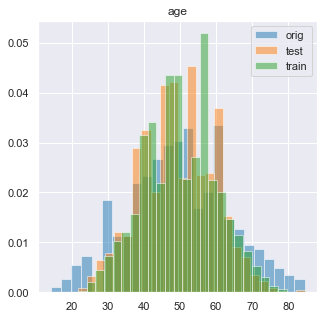

/home/mnotter/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mnotter/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


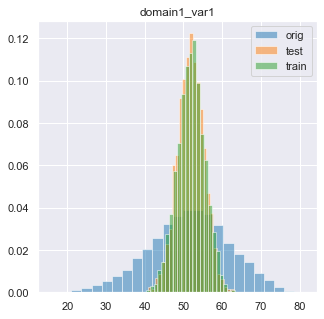

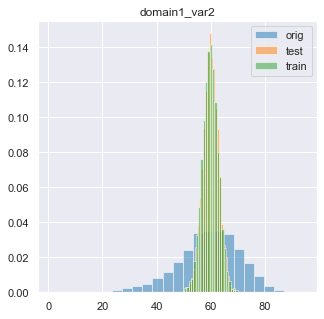

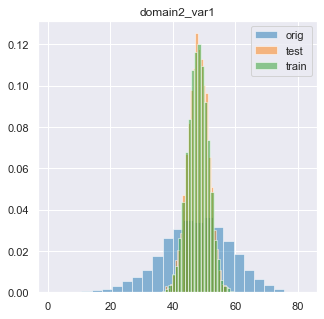

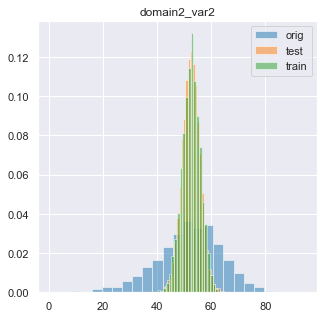

Score: 0.1571 | -0.1435 -0.1501 -0.1478 -0.1800 -0.1737


In [20]:
datasets_to_check = ['short_merge']

for dataset_id in datasets_to_check:

    predictions = {}
    scores = []
    grids = []

    for tidx, target in enumerate(['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']):

        print('Starting with dataset %s - target: %s' % (dataset_id, target))
        estimator = Ridge()
        df_pred, pred_tr, pred_te, grid, idx = run_prediction(model_metric,
            dataset_id=dataset_id, target=target, estimator=estimator,
            scaler_targets=scaler_targets, tidx=tidx)
        
        display_grid_optimization_details(grid)

        predictions['%s_tr' % target] = pred_tr
        predictions['%s_te' % target] = pred_te
        predictions['%s_miss' % target] = idx
        
        scores.append(grid.best_score_)
        grids.append(grid)

    # Display grids summary
    grids_summary(grids)
    
    # Compute overall score
    weights = [.3, .175, .175, .175, .175]
    score = np.sum([-s * weights[i] for i, s in enumerate(scores)])
    score_postfix = [int(score*10000)] + [-int(s*10000) for i, s in enumerate(scores)]

    df_results_tr, df_results_te = save_results(
        predictions, scaler_targets, targets, test_id, feature_transform,
        sample_submission, dataset_id, score_postfix)

    plot_prediction_distributions(targets, scaler_targets, df_results_tr, df_results_te)
    
    # Feedback of overall score
    txt = 'Score: {:.4f} | {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(score, *scores)
    print(txt)